[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/PennNGG/Quantitative-Neuroscience/blob/master/Concepts/Python/Multiple%20Comparisons.ipynb)

# Definitions

The multiple comparisons problem in statistics occurs when multiple statistical inferences are done simultaneously, which greatly increases the probability that any one inference will yield an erroneous result, by chance. A lot has been written about this problem, including:

- [Its prevalence in fMRI data analysis](https://www.sciencedirect.com/science/article/pii/S1053811912007057?via%3Dihub) (including a compelling illustration by this [prizewinning study](https://blogs.scientificamerican.com/scicurious-brain/ignobel-prize-in-neuroscience-the-dead-salmon-study/)\)

- [How Baysian methods can avoid the problem](http://www.stat.columbia.edu/~gelman/research/published/multiple2f.pdf).

- [General approaches for correcting for multiple comparisons](http://www.biostathandbook.com/multiplecomparisons.html).

Here we will provide some intuition for the problem using a simple thought experiment, to sensitize you to how much of a problem it can be. Consider performing the same statistical test on *N* different samples corresponding to, say, different voxels in fMRI data, using a *p*-value of $\alpha$ (typically 0.05) for each test. 

Thus, for any one test, the probability of getting a Type I error (rejecting $H_0$ when $H_0$ is true) is $\alpha$:

$p_{error}=\alpha$

For two tests, the probably of getting a Type I error for either test is just one minus the combined probability of not getting a Type I error from either one:

$p_{error}=1-(1-\alpha)(1-\alpha)$

For *N* tests, the probably of getting a Type I error for either test is just one minus the combined probability of not getting a Type I error from any one:

$p_{error}=1-(1-\alpha)^N$

Run the cell below to see that the probability of getting a Type I error under these conditions grows rapidly with *N*, implying that it becomes very, very likely that you will get a "statistically significant result" just by chance if you do enough tests:

Text(0, 0.5, '$P_{error}$')

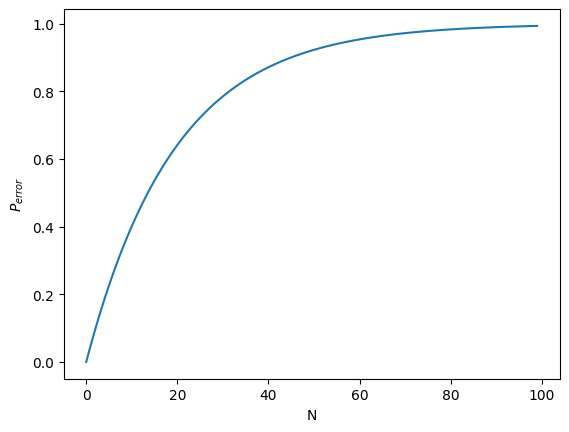

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

alpha = 0.05
N = np.arange(0,100)
plt.plot(N, 1-(1-alpha)**N)
plt.xlabel('N')
plt.ylabel('$P_{error}$')

# Correcting for multiple comparisons



There are a number of different methods that can be used to [correct for this problem](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5506159/). Below are two common methods.




## Bonferroni correction

The simplest way to correct for Type I errors (false positives) in multiple comparisons is to divide $\alpha$ by the number of comparisons, known as the [Bonferroni correction](https://mathworld.wolfram.com/BonferroniCorrection.html). This is a very conservative test that is typically used when the number of comparisons is relatively small and you want to avoid Type I errors.

## Benjamini–Hochberg procedure


Another approach is to more carefully control the false-discovery rate using the [Benjamini–Hochberg procedure](https://www.jstor.org/stable/2346101?seq=1#metadata_info_tab_contents):

1\. Rank the individual *p*-values in ascending order, labeled *i*=1...*n*

2\. For each *p*-value, calculate its "critical value" as (*i*/*n*)*Q*, where *i* is the rank, *n* is the total number of tests, and *Q* is the false discovery rate (a percentage) that you choose (typically 0.05).

3\. In your rank-ordered, original *p*-values, find the largest value that is smaller than its associated critical value; this *p*-value is the new criterion (i.e., reject $H_0$ for all cases for which *p* ≤ this value).

# Exercise

In this exercise we will run through an example of correcting for multiple comparisons with both the Benjamini-Hochberg procedure and the more conservative Bonferroni correction. 

First, simulate multiple (say, 1000) t-tests comparing two samples with equal means and standard deviations, and save the p-values. Obviously, at p<0.05 we expect that ~5% of the simulations to yield a "statistically significant" result (of rejecting the NULL hypothesis that the samples come from distributions with equal means).

Second, once you have the simulated p-values, apply both methods to address the multiple comparisons problem.

Third, set the sample 1 and sample 2 means to be 1 and 2 respectively, and re-run the exercise. What do you notice? What if you make the difference between means even greater?

In [47]:
def simulation(mean_1,std_dev1, mean_2, std_dev2,num_tests):

    t_stat_list = []
    p_value_list = []

    for i in range(num_tests):
        sample_1 = np.random.normal(mean_1,std_dev1, size= num_tests)
        sample_2 = np.random.normal(mean_2,std_dev2, size= num_tests)

        t_stat, p_value = stats.ttest_ind(sample_1, sample_2)
        #print(t_stat,p_value)
        t_stat_list.append(t_stat)
        p_value_list.append(p_value)
    
    plt.hist(sample_1, label='Sample 1', color='blue', linestyle='-', linewidth=2)

# Plot Sample 2
    plt.hist(sample_2, label='Sample 2', color='orange', linestyle='--', linewidth=2)
    return t_stat_list, p_value_list

    #p_value_list = np.array(p_value_list)


# Bonferroni Correction

In [76]:
def bonferroni(p_values, alpha, num_tests):
    bonferroni_correction = alpha / num_tests 
    adjusted_p_values = p_values * num_tests

    adjusted_p_values_capped = np.minimum(adjusted_p_values,1)
    print(len(adjusted_p_values_capped))
    bf_corrected_p_values = []

    for i in range(len(adjusted_p_values_capped)): 
        if adjusted_p_values_capped[i] < bonferroni_correction: 
            bf_corrected_p_values.append(adjusted_p_values_capped[i])
        else: 
            pass

    #print(len(bf_corrected_p_values))
    return bf_corrected_p_values

#print(bf_corrected_p_values)

# Benjamini-Hochberg Procedure


In [24]:
def benjamini_hochberg(p_values, alpha=0.05):
    # Step 1: Sort p-values and get their indices
    p_values = np.array(p_values)
    sorted_indices = np.argsort(p_values)
    print(sorted_indices[0:10])
    sorted_p_values = p_values[sorted_indices]
    print(sorted_p_values[0:10])
    
    # Step 2: Calculate the adjusted p-values
    m = len(p_values)
    adjusted_critical_values = (np.arange(1, m + 1) / m) * alpha
    print(adjusted_critical_values[0:10])
    
    # Step 3: Determine which p-values are significant
    significant = sorted_p_values <= adjusted_critical_values

    print(significant[0:10])
    
    # Step 4: Find the largest significant p-value and adjust others
    if np.any(significant):
        max_significant_index = np.max(np.where(significant))
        significant_indices = sorted_indices[:max_significant_index + 1]
    else:
        significant_indices = []
    
    return significant_indices

0
[803 892 717 874 382 327 265 524  15 336]
[0.00228219 0.00370452 0.00405822 0.0059251  0.00609305 0.00823432
 0.00912833 0.00993955 0.01035567 0.0104086 ]
[5.0e-05 1.0e-04 1.5e-04 2.0e-04 2.5e-04 3.0e-04 3.5e-04 4.0e-04 4.5e-04
 5.0e-04]
[False False False False False False False False False False]


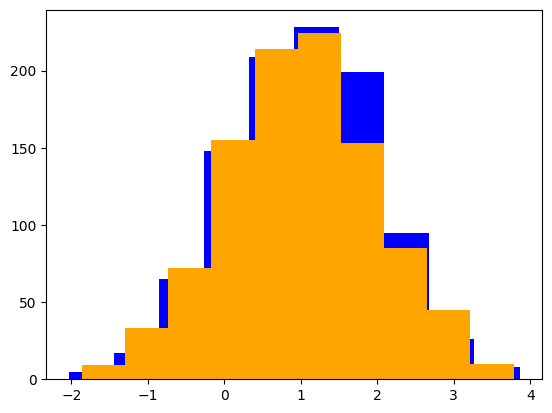

In [70]:
p_value_list = simulation(1,1,1,1,1000)[1]
bonferroni_correction_ = bonferroni(p_value_list,0.05, 1000)
bh_procedure = benjamini_hochberg(p_value_list,0.05)

In [72]:
print(f'You had a significant result {(len(p_value_list)/1000)} % of the time')

print(f"Percentage of significant tests after Bonferroni Correction: {(len(bonferroni_correction_)/1000)} %")

print(f'Percentage of signficant tests after Benjamini-Hochberg Procedure: {len(bh_procedure)/1000} %')

You had a significant result 1.0 % of the time
Percentage of significant tests after Bonferroni Correction: 0.0 %
Percentage of signficant tests after Benjamini-Hochberg Procedure: 0.0 %


1000000
[231 333 402 611 694 234 847  98 919 889]
[1.78416574e-129 4.79896952e-126 7.96273221e-123 1.10405528e-122
 2.66385209e-122 2.26990340e-121 6.08354865e-121 1.73626765e-120
 6.48911785e-120 7.84818138e-120]
[5.0e-05 1.0e-04 1.5e-04 2.0e-04 2.5e-04 3.0e-04 3.5e-04 4.0e-04 4.5e-04
 5.0e-04]
[ True  True  True  True  True  True  True  True  True  True]


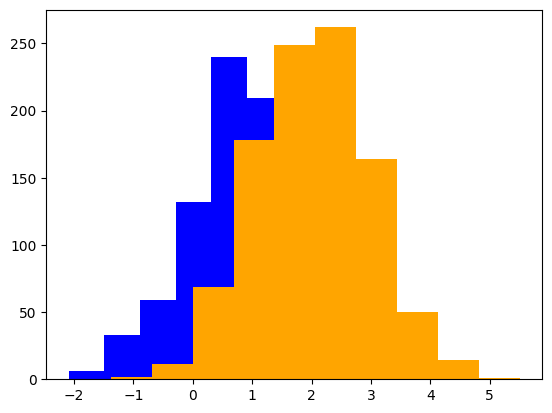

In [75]:
p_value_list = simulation(1,1,2,1,1000)[1]
bonferroni_correction_ = bonferroni(p_value_list,0.05, 1000)
bh_procedure = benjamini_hochberg(p_value_list,0.05)

In [69]:
print(f'You had a significant result {(len(p_value_list)/1000)} % of the time')

print(f"Percentage of significant tests after Bonferroni Correction: {(len(bonferroni_correction_)/1000)} %")

print(f'Percentage of signficant tests after Benjamini-Hochberg Procedure: {len(bh_procedure)/1000} %')

You had a significant result 1.0 % of the time
Percentage of significant tests after Bonferroni Correction: 1000.0 %
Percentage of signficant tests after Benjamini-Hochberg Procedure: 1.0 %


# Additional Resources


How to correct for multiple comparisons in [Matlab](https://www.mathworks.com/help/stats/multcompare.html), [R](https://stat.ethz.ch/R-manual/R-devel/library/stats/html/p.adjust.html), and [Python](https://www.statsmodels.org/dev/generated/statsmodels.stats.multitest.multipletests.html)

# Credits

Copyright 2021 by Joshua I. Gold, University of Pennsylvania